# Data Collection

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')
#https://www.imageclef.org/2023/medical/vqa
#https://huggingface.co/Salesforce/blip-vqa-base
#https://github.com/salesforce/BLIP

Mounted at /content/gdrive


In [ ]:
#import
import zipfile
import os
import json

In [ ]:
#functions

#unzip
def unzip(path_to_zip_file, directory_to_extract_to):
  if os.path.isdir(directory_to_extract_to) == False:
    os.mkdir(directory_to_extract_to)
  with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
#load json
def load_json(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

In [ ]:
%%time
#unzipping
unzip('/content/gdrive/MyDrive/CLEF_MEDQVA/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset.zip',
      '/content/gdrive/MyDrive/CLEF_MEDQVA/')
#unzipping
unzip('/content/gdrive/MyDrive/CLEF_MEDQVA/ImageCLEFmed-MEDVQA-GI-2023-Testing-Dataset.zip',
      '/content/gdrive/MyDrive/CLEF_MEDQVA/')

CPU times: user 10.7 s, sys: 3.07 s, total: 13.8 s
Wall time: 1min 13s


# Preprocessing

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')
#https://www.imageclef.org/2023/medical/vqa
#https://huggingface.co/Salesforce/blip-vqa-base
#https://github.com/salesforce/BLIP

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!pip install --quiet pycocoevalcap
!git clone https://github.com/salesforce/BLIP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.7 MB/s eta 0:00:00
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 277 (delta 153), reused 247 (delta 151), pack-reused 0
Receiving objects: 100% (277/277), 7.03 MiB | 20.70 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [ ]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import json
import sklearn
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import torch
import torchvision
import sys
import os
sys.path.insert(0, '/content/BLIP')
import BLIP
from BLIP.data.utils import pre_question

In [ ]:
#functions

#load json
def load_json(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data
#load the data
def load_df(dataset):
  #iterate
  data_ann = []
  for data in dataset:
    image_id = data['ImageID']
    for label in data['Labels']:
      question = label['Question']
      ans_type = label['AnswerType']
      ans = label['Answer']
      data_ann.append([image_id, question, ans_type, ans])
  #convert
  df = pd.DataFrame(data_ann, columns = ['ImageID', 'Question', 'AnswerType', 'Answer'])
  #return
  return df
#filepaths
def get_filepaths(row, train_path):
  image_path = train_path + 'images/' + row['ImageID'] + '.jpg'
  #if
  if row['AnswerType'] == 'segmentation':
    mask_path = train_path + 'masks/' + row['ImageID'] + '.jpg'
  else:
    mask_path = pd.NA
  return image_path, mask_path
#split data
def split_data(df, test_size):
  #split
  ls_train, ls_val = train_test_split(list(df['ImageID'].unique()), test_size = test_size, random_state = 42)
  #specify
  df_train = df[df['ImageID'].isin(ls_train)]
  df_val = df[df['ImageID'].isin(ls_val)]
  #update
  df_train['DATA'] = 'TRAIN'
  df_val['DATA'] = 'VAL'
  #combine
  df_new = pd.concat([df_train, df_val]).reset_index(drop = True)
  return df_new
#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc
#prepare images
def prepare_images(row, interpolate, normalize, save_path, save_folder):
  #read in the image tensor
  img_tensor = torchvision.io.read_image(row['Image'])
  #prepare
  img_tensor = interpolate(img_tensor)
  img_tensor = img_tensor.to(torch.float32)
  img_tensor = normalize(img_tensor)
  image = sitk.GetImageFromArray(img_tensor.numpy())
  #save the images
  return save_image(save_path, save_folder, row['ImageID'], image)
#reconcile a single row of missing data and misspelling of the questions
def reconcile(row):
  ques = row['Question']
  ans = row['Answer']
  if (row['Question'] == 'How many instrumnets are in the image?') and (row['AnswerType'] == 'Number'):
    ques = 'How many instruments are in the image?'
  if (row['ImageID'] == 'cl8k2u1rr1gm30832fz9x3vru') and (row['Question'] == 'How many instrumnets are in the image?') and (row['AnswerType'] == 'Number'):
    ans = ['0']
  return ques, ans
#combine
def comb_list_ele(ls):
  return ','.join(map(str, ls))
#prepare text
def prepare_text(row, max_len = 150):
  #question
  question = pre_question(row['Question'], max_len)
  #answers list elements are mutually exclusive
  answers = [pre_question(comb_list_ele(row['Answer']), max_len)]
  #answers = []
  #for answer in row['Answer']:
    #answers.append(pre_question(answer))
  #weights (should generally be consistent, unless multiple correct answers that are mutually exlcusive see original paper)
  #if override:
  weights = [1.0 for i in range(len(answers))]
  #else:
    #answer_weight = {}
    #for answer in answers:
      #if answer in answer_weight.keys():
        #answer_weight[answer] += 1/len(answer)
      #else:
        #answer_weight[answer] = 1/len(answer)
    #weights = list(answer_weight.values())
  #return
  return question, answers, weights

In [ ]:
#init
train_path = '/content/gdrive/MyDrive/CLEF_MEDQVA/data/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset/'
#split
val_size = 0.2
#input_size
input_size = (224, 224)
#save path
save_path = '/content/gdrive/MyDrive/CLEF_MEDQVA/preprocessing/'
#save folder
save_folder = 'Norm-Image'

In [ ]:
%%time
#main

#read the json file
dataset = load_json(train_path + 'gt.json')
#load the data
df = load_df(dataset)
#get file path and mask info
df['Image'], df['Mask'] = zip(*df.apply(get_filepaths, axis = 1, args = (train_path, )))
#eliminate masks for VQA
df = df[df['AnswerType'] != 'segmentation']
#split the data
df = split_data(df, val_size)
#reconcile
df['Question'], df['Answer'] = zip(*df.apply(reconcile, axis = 1))
#process text
df['Input_Question'], df['Input_Answer'], df['Input_Weight'] = zip(*df.apply(prepare_text, axis = 1))
#interpolate
interpolate = torchvision.transforms.Resize((input_size[0], input_size[1]),
                                            interpolation = torchvision.transforms.functional.InterpolationMode.BICUBIC)
#normalize
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
 (0.26862954, 0.26130258, 0.27577711))
#preprocess the images
df['Norm_Image'] = df.apply(prepare_images, axis = 1, args = (interpolate, normalize, save_path, save_folder))
#save
df.to_pickle(save_path + save_folder + '/' + 'df_inputs.pkl')

Might want to change in image size and especially input weights. Keep in mind num_beams for the custom.

# Training

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')
#https://www.imageclef.org/2023/medical/vqa
#https://huggingface.co/Salesforce/blip-vqa-base
#https://github.com/salesforce/BLIP

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!git clone https://github.com/salesforce/BLIP
#!pip install --quiet transformers
!pip install --quiet transformers=='4.16' #need this for the GITHUB models to work
!pip install --quiet timm
!pip install --quiet wandb
!pip install --quiet pycocoevalcap
!pip install --quiet fairscale

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.8 MB/s eta 0:00:00
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 277 (delta 153), reused 247 (delta 151), pack-reused 0
Receiving objects: 100% (277/277), 7.03 MiB | 26.10 MiB/s, done.
Resolving deltas: 100% (153/153), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 M

In [ ]:
#imports
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import SimpleITK as sitk
import torch
import torchvision
import random
import sys
import time
import torch.backends.cudnn as cudnn
import datetime
from datetime import datetime
import wandb
sys.path.insert(0, '/content/BLIP')
from BLIP.data import create_loader
from BLIP.data.vqa_dataset import vqa_collate_fn
from BLIP.models.blip_vqa import blip_vqa
from BLIP.utils import cosine_lr_schedule
from BLIP import utils
from BLIP.data.utils import save_result

if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings

Device:  Tesla T4


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#functions
#create the dataset and batch_fn
class CustomImageDataset(torch.utils.data.Dataset):
  #init
  def __init__(self, df, data, col_image, aug = False):
    self.df = df[df['DATA'] == data]
    self.col_image = col_image
    self.aug = aug
  #len
  def __len__(self):
    return len(self.df)
  #get item
  def __getitem__(self, idx):
    #row
    row = self.df.iloc[idx]
    #image
    image = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])))
    #image = image.half()
    #augment?
    if self.aug:
      if random.random() > 0.5:
        image = torchvision.transforms.functional.vflip(image)
      if random.random() > 0.5:
        image = torchvision.transforms.functional.hflip(image)
    #question
    question = row['Input_Question']
    #answer
    answers = row['Input_Answer']
    #weights
    weights = row['Input_Weight']
    #return
    return image, question, answers, weights

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load json file
def load_params(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)
  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False
  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #cosine
  if model_config['scheduler']['description'] == 'cosine':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max = model_config['epochs'],
                                                           eta_min = model_config['scheduler']['eta_min'],
                                                           verbose = True
                                                           )
  #return
  return scheduler

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'VQA_BLIP':
    #can also hardcode this section
    kwargs = {'med_config': model_config['architecture']['med_config']}
    model = blip_vqa(pretrained = model_config['architecture']['pretrained'],
                     image_size = model_config['architecture']['image_size'],
                     vit = model_config['architecture']['vit'],
                     vit_grad_ckpt = model_config['architecture']['vit_grad_ckpt'],
                     vit_ckpt_layer = model_config['architecture']['vit_ckpt_layer'],
                     **kwargs)
  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, image, weights, loss = (None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('2d-medvqa-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #get the training data
    dset_train = CustomImageDataset(df = df, data = 'TRAIN', col_image = model_config['col_image'], aug = model_config['aug'])
    #get the validation data
    dset_val = CustomImageDataset(df = df, data = 'VAL', col_image = model_config['col_image'], aug = False)
    #get the loaders
    dset = [dset_train, dset_val]
    train_loader, val_loader = create_loader(dset, [None, None],
     [model_config['train_batch_size'], model_config['val_batch_size']],
      [2, 2], [True, False], [vqa_collate_fn, vqa_collate_fn]) #2 is num workers

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):

      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #metric logging
      metric_logger = utils.MetricLogger(delimiter = "  ")
      metric_logger.add_meter('lr', utils.SmoothedValue(window_size = 1, fmt = '{value:.6f}'))
      metric_logger.add_meter('loss', utils.SmoothedValue(window_size = 1, fmt = '{value:.4f}'))
      header = 'Train Epoch: [{}]'.format(epoch)
      print_freq = model_config['train_batch_size'] #int(model_config['batch_size'] / len(train_loader))
      #iterate through the training data
      for i, (image, question, answer, weights, n) in enumerate(metric_logger.log_every(train_loader, print_freq, header)):
        #zero optimizer
        optimizer.zero_grad()
        #forward pass with autograd
        with torch.amp.autocast(device, torch.float16):
          image, weights = image.to(device, non_blocking=True), weights.to(device, non_blocking=True)
          loss = model(image, question, answer, train=True, n=n, weights=weights)
        #backward
        loss.backward()
        #step
        optimizer.step()
        #update metrics
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        #log into json file
        train_epoch_loss = train_epoch_loss + loss.item()
        #clear
        image, weights, loss = (None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #loss
      train_loss = train_epoch_loss / len(train_loader)
      #accuracy
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #metric logging
      metric_logger = utils.MetricLogger(delimiter = "  ")
      metric_logger.add_meter('lr', utils.SmoothedValue(window_size = 1, fmt = '{value:.6f}'))
      metric_logger.add_meter('loss', utils.SmoothedValue(window_size = 1, fmt = '{value:.4f}'))
      header = 'Val Epoch: [{}]'.format(epoch)
      print_freq = model_config['val_batch_size'] #int(model_config['batch_size'] / len(val_loader))
      #iterate through the validation data
      for i, (image, question, answer, weights, n) in enumerate(metric_logger.log_every(val_loader, print_freq, header)):
        #no grad
        with torch.no_grad():
          #forward pass with autograd
          with torch.amp.autocast(device, torch.float16):
            image, weights = image.to(device, non_blocking=True), weights.to(device, non_blocking=True)
            loss = model(image, question, answer, train=True, n=n, weights=weights)
        #update metrics
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        #log into json file
        val_epoch_loss = val_epoch_loss + loss.item()
        #clear
        image, weights, loss = (None, None, None)
        if device == 'cuda':
          torch.cuda.empty_cache()
      #loss
      val_loss = val_epoch_loss / len(val_loader)
      #accuracy
      val_acc = 1 - val_loss

      #scheduler
      if model_config['scheduler']['description'] == 'plateau':
        scheduler.step(train_loss)
      if model_config['scheduler']['description'] == 'cosine':
        scheduler.step()

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)
      #wont log lossess or acc after early stopping or save best model
      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc
      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc
      #keep track of each epoch
      model_config['epochs_trained'] = epoch
      #wandb
      wandb.log(model_config)

      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)
      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, image, weights, loss = (None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Visual Question Answering for Medical Imaging'},
        #project in wandb
        'project':{'value': 'MEDVQA'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/CLEF_MEDQVA/preprocessing/Norm-Image/df_inputs.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/CLEF_MEDQVA/results/'},
        'col_image': {'value': 'Norm_Image'}, #input column of the csv
        'device': {'value': gpu},
        #model architecture
        'architecture': {'values': [
            {'description': 'VQA_BLIP',
             'med_config': '/content/BLIP/configs/med_config.json',
             'pretrained': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth',
             'image_size': 224,
             'vit': 'base',
             'vit_grad_ckpt': False,
             'vit_ckpt_layer': 0
             }
        ]},
        #training params
        'aug': {'values': [False]},
        'train_batch_size': {'values': [50]}, #50 - 55 base
        'val_batch_size': {'values': [120]}, #180 240
        'init_lr': {'values': [5e-5]},
        'epochs': {'values': [10]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 2}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-8]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'cosine',
             'eta_min': 0}
            ]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 5,
            'delta': 1e-2, #1e-2 or 5e-3
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}

In [ ]:
#%%time
#main script

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('2d-medvqa-sweep-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

Create sweep with ID: evn09plw
Sweep URL: https://wandb.ai/anishsalvi-osail/MEDVQA/sweeps/evn09plw


wandb: Agent Starting Run: z2h2upm4 with config:
wandb: 	architecture: {'description': 'VQA_BLIP', 'image_size': 224, 'med_config': '/content/BLIP/configs/med_config.json', 'pretrained': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth', 'vit': 'base', 'vit_ckpt_layer': 0, 'vit_grad_ckpt': False}
wandb: 	aug: False
wandb: 	col_image: Norm_Image
wandb: 	data_path: /content/gdrive/MyDrive/CLEF_MEDQVA/preprocessing/Norm-Image/df_inputs.pkl
wandb: 	description: Visual Question Answering for Medical Imaging
wandb: 	device: Tesla T4
wandb: 	early_stopping: {'best_model': None, 'delta': 0.01, 'model_criteria': False, 'patience': 5, 'stopped_early': None}
wandb: 	epochs: 10
wandb: 	epochs_trained: 0
wandb: 	init_lr: 5e-05
wandb: 	log_train_acc: None
wandb: 	log_train_loss: None
wandb: 	log_val_acc: None
wandb: 	log_val_loss: None
wandb: 	model: None
wandb: 	optimizer: AdamW
wandb: 	project: MEDVQA
wandb: 	save_after_n_epochs: 2
wandb: 	s

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.35G/1.35G [00:13<00:00, 105MB/s]


reshape position embedding from 900 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth
Adjusting learning rate of group 0 to 5.0000e-05.
Train Epoch: [1]  [  0/576]  eta: 3:15:10  lr: 0.000050  loss: 42.3695  time: 20.3314  data: 11.2906  max mem: 9634
Train Epoch: [1]  [ 50/576]  eta: 0:30:10  lr: 0.000050  loss: 9.0326  time: 2.3810  data: 1.0286  max mem: 12510
Train Epoch: [1]  [100/576]  eta: 0:21:18  lr: 0.000050  loss: 8.6683  time: 1.8083  data: 0.4210  max mem: 12510
Train Epoch: [1]  [150/576]  eta: 0:16:57  lr: 0.000050  loss: 6.7029  time: 1.7762  data: 0.3545  max mem: 12510
Train Epoch: [1]  [200/576]  eta: 0:14:03  lr: 0.000050  loss: 6.5028  time: 1.7889  data: 0.3655  max mem: 12510
Train Epoch: [1]  [250/576]  eta: 0:11:37  lr: 0.000050  loss: 5.8714  time: 1.7348  data: 0.3643  max mem: 12510
Train Epoch: [1]  [300/576]  eta: 0:09:34  lr: 0.000050  loss: 7.2160  time: 1.8154  data: 0.38

aug,▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▂▃▃▄▅▆▆▇█
init_lr,▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁
train_acc,▁▇▇▇▇▇████
train_batch_size,▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▁▁▁▁
val_acc,▁▂▆▆▆▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Inference

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')
#https://www.imageclef.org/2023/medical/vqa
#https://huggingface.co/Salesforce/blip-vqa-base
#https://github.com/salesforce/BLIP

Mounted at /content/gdrive


In [ ]:
#installations
!pip install --quiet SimpleITK
!git clone https://github.com/salesforce/BLIP
#!pip install --quiet transformers
!pip install --quiet transformers=='4.16' #need this for the GITHUB models to work
!pip install --quiet timm
!pip install --quiet fairscale

fatal: destination path 'BLIP' already exists and is not an empty directory.


In [ ]:
#imports
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import SimpleITK as sitk
import torch
import numpy as np
import torchvision
import random
import sys
import time
import datetime
import glob
from datetime import datetime
sys.path.insert(0, '/content/BLIP')
from BLIP.models.blip_vqa import blip_vqa

if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device:  Tesla T4


In [ ]:
#functions
#create the dataloader and batch_fn
class CustomImageDataset(torch.utils.data.Dataset):
  #init
  def __init__(self, df, col_image, aug = False):
    self.df = df
    self.col_image = col_image
    self.aug = aug
  #len
  def __len__(self):
    return len(self.df)
  #get item
  def __getitem__(self, idx):
    #row
    row = self.df.iloc[idx]
    #image
    image = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row[self.col_image])))
    #image = image.half()
    #augment?
    if self.aug:
      if random.random() > 0.5:
        image = torchvision.transforms.functional.vflip(image)
      if random.random() > 0.5:
        image = torchvision.transforms.functional.hflip(image)
    #question
    question = row['Input_Question']
    #answer
    answers = row['Input_Answer']
    #weights
    weights = row['Input_Weight']
    #return
    return image, question, answers, weights

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load json file
def load_params(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the model
def get_model(model_config):
  #get the model for smp unet
  if model_config['architecture']['description'] == 'VQA_BLIP':
    #can also hardcode this section
    kwargs = {'med_config': model_config['architecture']['med_config']}
    model = blip_vqa(pretrained = None,
                     image_size = model_config['architecture']['image_size'],
                     vit = model_config['architecture']['vit'],
                     vit_grad_ckpt = model_config['architecture']['vit_grad_ckpt'],
                     vit_ckpt_layer = model_config['architecture']['vit_ckpt_layer'],
                     **kwargs)
  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

In [ ]:
#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/CLEF_MEDQVA/results/2d-medvqa-sweep-2023-06-25-03-15-08/'
#specify the model tag
model_tag = '2d-medvqa'

In [ ]:
#main

%%time

#init
model = None
#reset
if device == 'cuda':
  torch.cuda.empty_cache()

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the input file
  df = pd.read_pickle(model_config['data_path'])
  #need to obtain the data
  ls_df = split_given_size(df, model_config['val_batch_size']) #num patients in batch (estimate)
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  ls_results = []
  #load the data
  dset_infer = CustomImageDataset(df, model_config['col_image'], aug = False)
  #load
  infer_loader = torch.utils.data.DataLoader(dset_infer, batch_size = model_config['val_batch_size']) #can change the batch size!
  #infer
  for i, (image, question, _, _) in enumerate(infer_loader):
    #get the small df
    df_small = ls_df[i]
    #less compute
    with torch.no_grad():
      #autograd
      with torch.amp.autocast(device, torch.float16):
        #forward pass
        image = image.to(device, non_blocking=True)
        #forward
        answers = model(image, question, train=False, inference='generate')
      #clear
      image = None
      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()
    #set
    df_small['Prediction'] = answers
    #append
    ls_results.append(df_small)
    #print
    print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #save the results
  df_results = pd.concat(ls_results)
  #save
  df_results.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #clear
  model = None
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

Finished Batch: 1 of 400
Finished Batch: 2 of 400
Finished Batch: 3 of 400
Finished Batch: 4 of 400
Finished Batch: 5 of 400
Finished Batch: 6 of 400
Finished Batch: 7 of 400
Finished Batch: 8 of 400
Finished Batch: 9 of 400
Finished Batch: 10 of 400
Finished Batch: 11 of 400
Finished Batch: 12 of 400
Finished Batch: 13 of 400
Finished Batch: 14 of 400
Finished Batch: 15 of 400
Finished Batch: 16 of 400
Finished Batch: 17 of 400
Finished Batch: 18 of 400
Finished Batch: 19 of 400
Finished Batch: 20 of 400
Finished Batch: 21 of 400
Finished Batch: 22 of 400
Finished Batch: 23 of 400
Finished Batch: 24 of 400
Finished Batch: 25 of 400
Finished Batch: 26 of 400
Finished Batch: 27 of 400
Finished Batch: 28 of 400
Finished Batch: 29 of 400
Finished Batch: 30 of 400
Finished Batch: 31 of 400
Finished Batch: 32 of 400
Finished Batch: 33 of 400
Finished Batch: 34 of 400
Finished Batch: 35 of 400
Finished Batch: 36 of 400
Finished Batch: 37 of 400
Finished Batch: 38 of 400
Finished Batch: 39 of

# Evaluation

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')
#https://www.imageclef.org/2023/medical/vqa
#https://huggingface.co/Salesforce/blip-vqa-base
#https://github.com/salesforce/BLIP
#https://medium.com/@mikeusru/common-metrics-for-evaluating-natural-language-processing-nlp-models-e84190063b5f
#https://docs.oneai.com/docs/rouge-metrics-for-summary-headline#:~:text=Rouge%20metrics%20measure%20the%20word,50%20are%20considered%20excellent%20results.
#BERTSCORE
#https://kierszbaumsamuel.medium.com/f1-score-in-nlp-span-based-qa-task-5b115a5e7d41

Mounted at /content/gdrive


In [ ]:
#pip install
!pip install --quiet evaluate
!pip install --quiet rouge_score
#!pip install --quiet SimpleITK
#!pip install --quiet timm
#!pip install --quiet fairscale
#!git clone https://github.com/salesforce/BLIP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#imports
import evaluate
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
#import SimpleITK as sitk
import numpy as np
#import sys
#sys.path.insert(0, '/content/BLIP')
#import BLIP
#from BLIP.models.blip import init_tokenizer

In [ ]:
#functions

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load json file
def load_params(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get performance
def get_performance(df, col_pred, col_ans):
  #set
  predictions = df[col_pred].to_list()
  references = df[col_ans].to_list()
  #get results
  results = rouge.compute(predictions=predictions, references=references, use_aggregator = False)
  #put in dataframe
  df_metrics = pd.DataFrame.from_dict(results)
  #uppercase the columns
  df_metrics.columns = map(str.upper, df_metrics.columns)
  #if re-running
  df = df.drop(df_metrics.columns.to_list(), axis=1, errors='ignore')
  #return
  return pd.concat([df, df_metrics], axis = 1)

#metrics
def get_metrics(df, model_config, datasets = ['TRAIN', 'VAL'],
                metrics = ['ROUGE1', 'ROUGE2', 'ROUGEL', 'ROUGELSUM'], measures = ['mean']):
  #init
  results = {}
  #iterate
  for dataset in datasets:
    for metric in metrics:
      for measure in measures:
        results[dataset + '_' + metric + '_' + measure] = df[df['DATA'] == dataset][metric].describe()[measure]
  #insert
  model_config['results'] = results
  #return
  return model_config

#plotter
def plotter(row):
  plt.figure(figsize = (7, 7))
  plt.imshow(plt.imread(row['Image']))
  #plt.imshow(norm(np.moveaxis(sitk.GetArrayFromImage(sitk.ReadImage(row['Norm_Image'])), 0, 2)))
  plt.title('Q: ' + row['Question'] + '\nHuman Says: ' + row['Input_Answer'][0] + '\nModel Says: ' + row['Prediction'] + '\nRouge: ' + str(row['ROUGELSUM']))
  plt.show()

#plot
def pose_image_question(df, data, filt_type, filt, num_samples, metric = 'ROUGELSUM'):
  #set
  df = df[df['DATA'] == data]
  df = df[df[filt_type] == filt]
  df = df.sort_values(by = [metric])
  #get average
  df_mid = df.iloc[int((len(df)/2) - int(num_samples/2)):int((len(df)/2) + int(num_samples/2))]
  #concat
  df_dist = pd.concat([df.head(num_samples), df_mid, df.tail(num_samples)])
  #plot
  _ = df_dist.apply(plotter, axis = 1)

#norm
def norm(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
#specify the sweep folder
sweep_path = '/content/gdrive/MyDrive/CLEF_MEDQVA/results/2d-medvqa-sweep-2023-06-25-03-15-08/'
#specify the model tag
model_tag = '2d-medvqa'
#rank
rank = 'VAL_ROUGEL_mean'
#cols
cols = [
    'TRAIN_ROUGE1_mean',
    'TRAIN_ROUGE2_mean',
    'TRAIN_ROUGEL_mean',
    'TRAIN_ROUGELSUM_mean',
    'VAL_ROUGE1_mean',
    'VAL_ROUGE2_mean',
    'VAL_ROUGEL_mean',
    'VAL_ROUGELSUM_mean',
]
#plot some samples from the validation set ROUGE2 matters when more than one word

In [ ]:
#main
%%time


#init rouge
rouge = evaluate.load('rouge')
#view performance metrics
ls_metrics = []

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model_config = load_params(sweep_folder + '/model_config.json')
  #load in the results file
  df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
  #get performance
  df = get_performance(df, 'Prediction', 'Input_Answer')
  #get dataset metrics
  model_config = get_metrics(df, model_config)
  #save results
  df.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #save params
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

  #get data_config
  data_config = model_config['results']
  data_config['save_folder'] = model_config['save_folder']
  #append
  ls_metrics.append(data_config)

#convert
df_opt = pd.DataFrame(ls_metrics)
#rank
df_opt = df_opt.sort_values(by = [rank], ascending = False)
#display
display(df_opt[cols].round(2))
#save
df_opt.to_pickle(sweep_path + 'df_opt.pkl')
#show the model config
row = df_opt.iloc[0]
#read
model_config = load_params(row['save_folder'] + 'model_config.json')
#show params
df = pd.read_pickle(model_config['save_folder'] + 'df_results.pkl')
#print(model_config)

,TRAIN_ROUGE1_mean,TRAIN_ROUGE2_mean,TRAIN_ROUGEL_mean,TRAIN_ROUGELSUM_mean,VAL_ROUGE1_mean,VAL_ROUGE2_mean,VAL_ROUGEL_mean,VAL_ROUGELSUM_mean
0,0.91,0.41,0.91,0.91,0.88,0.39,0.88,0.88


CPU times: user 5.01 s, sys: 167 ms, total: 5.18 s
Wall time: 9.76 s


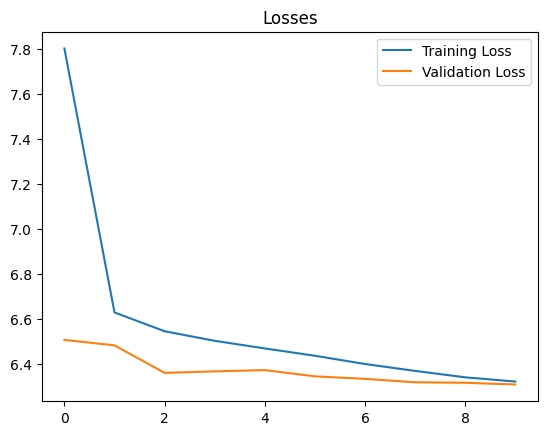

In [ ]:
#plot loss
plt.title('Losses')
plt.plot(model_config['log_train_loss'], label = 'Training Loss')
plt.plot(model_config['log_val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

#balancing term
#create column
#ROUGE2 mean fix it

In [ ]:
#breakdown by question type of best performing model
display(df.groupby(['DATA', 'Input_Question'])['ROUGE1', 'ROUGE2', 'ROUGELSUM'].mean().round(2))

<ipython-input-8-f0f2901c89fd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(df.groupby(['DATA', 'Input_Question'])['ROUGE1', 'ROUGE2', 'ROUGELSUM'].mean().round(2))


ROUGE1  ROUGE2  \
DATA  Input_Question                                                     
TRAIN are there any abnormalities in the image?           0.99    0.25   
      are there any anatomical landmarks in the image?    0.94    0.44   
      are there any instruments in the image?             0.95    0.54   
      have all polyps been removed?                       0.99    0.69   
      how many findings are present?                      0.87    0.00   
      how many instruments are in the image?              0.97    0.00   
      how many polyps are in the image?                   0.97    0.00   
      is there a green/black box artefact?                0.96    0.00   
      is there text?                                      0.97    0.00   
      is this finding easy to detect?                     0.86    0.00   
      what color is the abnormality?                      0.87    0.67   
      what color is the anatomical landmark?              0.96    0.96   
      what is the size of the polyp?                      0.82    0.81   
      what type of polyp is present?                      0.91    0.82   
      what type of procedure is the image taken from?     1.00    0.00   
      where in the image is the abnormality?              0.60    0.49   
      where in the image is the anatomical landmark?      0.84    0.81   
      where in the image is the instrument?               0.92    0.87   
VAL   are there any abnormalities in the image?           0.94    0.22   
      are there any anatomical landmarks in the image?    0.91    0.39   
      are there any instruments in the image?             0.91    0.47   
      have all polyps been removed?                       0.95    0.66   
      how many findings are present?                      0.82    0.00   
      how many instruments are in the image?              0.94    0.00   
      how many polyps are in the image?                   0.94    0.00   
      is there a green/black box artefact?                0.95    0.00   
      is there text?                                      0.96    0.00   
      is this finding easy to detect?                     0.86    0.00   
      what color is the abnormality?                      0.84    0.63   
      what color is the anatomical landmark?              0.95    0.95   
      what is the size of the polyp?                      0.75    0.74   
      what type of polyp is present?                      0.88    0.81   
      what type of procedure is the image taken from?     0.99    0.00   
      where in the image is the abnormality?              0.59    0.48   
      where in the image is the anatomical landmark?      0.85    0.81   
      where in the image is the instrument?               0.88    0.83   

                                                        ROUGELSUM  
DATA  Input_Question                                               
TRAIN are there any abnormalities in the image?              0.99  
      are there any anatomical landmarks in the image?       0.94  
      are there any instruments in the image?                0.95  
      have all polyps been removed?                          0.99  
      how many findings are present?                         0.87  
      how many instruments are in the image?                 0.97  
      how many polyps are in the image?                      0.97  
      is there a green/black box artefact?                   0.96  
      is there text?                                         0.97  
      is this finding easy to detect?                        0.86  
      what color is the abnormality?                         0.84  
      what color is the anatomical landmark?                 0.96  
      what is the size of the polyp?                         0.82  
      what type of polyp is present?                         0.91  
      what type of procedure is the image taken from?        1.00  
      where in the image is the abnormality?                 0.59  
      where in the 

In [ ]:
#breakdown by answer type of best performing model
display(df.groupby(['DATA', 'AnswerType'])['ROUGE1', 'ROUGE2', 'ROUGELSUM'].mean().round(2))

<ipython-input-9-9341618b6774>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(df.groupby(['DATA', 'AnswerType'])['ROUGE1', 'ROUGE2', 'ROUGELSUM'].mean().round(2))


ROUGE1  ROUGE2  ROUGELSUM
DATA  AnswerType                           
TRAIN Number        0.94    0.00       0.94
      Text          0.89    0.61       0.89
      Yes/No        0.95    0.17       0.95
VAL   Number        0.90    0.00       0.90
      Text          0.86    0.58       0.86
      Yes/No        0.93    0.16       0.93

In [ ]:
#pose a question or by answer type
pose_image_question(df, 'VAL', 'Input_Question', 'have all polyps been removed?', 20)